C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.el2c6ple4zyw3eceviv3oxxgrn2nrfm2.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


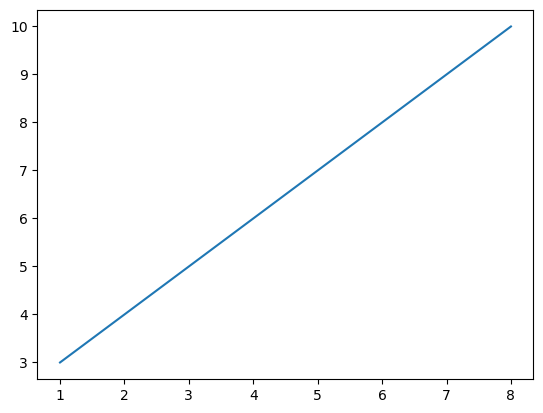

In [1]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.array([1, 8])
ypoints = np.array([3, 10])

plt.plot(xpoints, ypoints)
plt.show()

In [2]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces
import math
import pandas as pd
from gym import wrappers
from collections import deque
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [3]:
import pandas as pd 
from collections import deque
import gym

import os 
import numpy as np
import pybullet_envs
from random import sample
import torch as T 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import torch.multiprocessing as mp
from torch.distributions import Categorical,Normal,MultivariateNormal
from multiprocessing.pool import Pool
import random
from rltorch.network import create_linear_network,BaseNetwork
import torch
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import csv
import random
from math import sqrt

def calculate_distance(coord1, coord2):
    distance = sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)
#     print(distance)
    return distance

def generate_coordinates(num_coordinates):
    coordinates = []
    y =250
    x = 250
    i = 0
    while len(coordinates) < num_coordinates:
        if(i<8):
            y = y +20
            x = 250
            i = i+1
            new_coord = (x, y)
        elif(i<15):
            y = y
            x= x + 20
            new_coord = (x, y)
            i = i+1
        else:  
            y = random.uniform(0, 500)  # Adjust the range as needed
            x = random.uniform(0, 500)  # Adjust the range as needed
            new_coord = (x, y)

        # Check distance from existing coordinates
        if all(calculate_distance(new_coord, existing_coord) > 10 for existing_coord in coordinates):
            coordinates.append(new_coord)

    return coordinates

def save_to_csv(filename, coordinates):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['X', 'Y'])
        csv_writer.writerows(coordinates)

if __name__ == "__main__":
    num_coordinates = 26
    output_filename = 'coordinates.csv'

    generated_coordinates = generate_coordinates(num_coordinates)
    save_to_csv(output_filename, generated_coordinates)

    print(f"{num_coordinates} coordinates generated and saved to {output_filename}.")
dataset = pd.read_csv('coordinates.csv')
X = dataset.iloc[:, [0, 1]].values
def distance(u,v,w,x,y,z):
    distance = ((u-x)**2 + (v-y)**2 + (w-z)**2)**0.5
    return distance

26 coordinates generated and saved to coordinates.csv.


In [5]:
class Single_Agent_UAV(gym.Env):
    def __init__(self, initial_UAV_state = None):
        super(Single_Agent_UAV, self).__init__()

        self.initial_UAV_state = np.array([500,500])
        self.UE_count = len(X)
        self.Z = 20
        self.color = ['red', 'green', 'blue', 'cyan', 'magenta']
        self.max_angle = 2 * math.pi
        self.phi_n = np.radians(42.44)  # in degrees
        self.C_max_t = (self.Z / np.tan(self.phi_n))
        self.boundary_x = self.boundary_y = 500.
        self.max_episode_steps = 50 # Maximum number of steps in a single episode, after which environment returns done = True
        self._max_episode_steps = 50
        self.current_episode_timestep = 0
        self.done = False
        self.visited = np.array([0 for i in range(self.UE_count)])
        self.state_space_lb = np.array([0, 0], dtype = np.float32)
        self.state_space_ub = np.array([self.boundary_x, self.boundary_y], dtype = np.float32)
        
        # plotting parameters
        self.plotting_boundary_buffer = 5.
        self.UAV_coverage_circle_color = 'lavender'
        self.UAV_path_color = 'green'
        obh = []
        obl = []
        self.weight = []
        self.visited = np.array([0 for i in range(self.UE_count)])
        for i in range(len(X)+2):
            obh.append(float('inf')) 
        for i in range(len(X)+2):
            obl.append(float('-inf')) 
        high = np.array(obh, dtype=np.float32)
        low = np.array(obl, dtype=np.float32)
        high1 = np.array([len(X), 180.0, 6.0], dtype=np.float32)
        low1 = np.array([0, -180.0, 5.0], dtype=np.float32)
        
        self.observation_space = spaces.Box(low, high)
        #self.action_space = spaces.Box(low=low1, high=high1, dtype=np.float32)
        self.action_space = spaces.Box(-1, 1, (2,), dtype=np.float32)

        self.place_UEs(position="random")


    def reset(self):
        # RANDOMLY SELECTS UAV STARTING POSITION
        self.current_state = self.select_random_state()
        ground_UAV_state = self.current_state[:2]
        self.visited = np.array([0 for i in range(self.UE_count)])
        self.timesteps_in_episode = 0
        self.done = False
        obs = []
        obs.append(self.current_state[0])
        obs.append(self.current_state[1])
        for i in range(len(X)):
            obs.append(-(math.dist(self.UE_positions[i], ground_UAV_state))/1000)
        return np.array(obs)
    
    
    def get_count_of_UEs_covered(self):
        profit = 0
        ground_UAV_state = self.current_state[:2]
        for i in range(self.UE_count):
            if(math.dist(self.UE_positions[i], ground_UAV_state)<=self.C_max_t):
                if(self.visited[i]==0):
                    profit = profit + 100
                    self.visited[i] =1
                else:
                    profit = profit 
            else:
                if(self.visited[i]==0):
                    profit = profit -1
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
        # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
#         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
#         M_t = rho_array.sum()
        return profit


    def render(self, **kwargs):
        '''
        Function to visualize UAV position
        (this function has different configurations for different use cases)
        '''
        
        if 'UAV_positions_list' in kwargs:
            self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

        if 'fig' not in kwargs:
            fig, ax = plt.subplots(1, 1, figsize=(20,10))
            ax = np.array([ax])
            kwargs['fig'] = fig
            kwargs['ax'] = ax
            kwargs['i'] = 0
        
        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        self.render_position_plot(**kwargs)


    def step(self, action: np.ndarray):
        '''
        Takes action moving environment from current_state to next_state
        Arguments: `action` to be taken
        Returns: new_state, reward, done, info(=None)
        '''
        # action = action.numpy().flatten()
#         err_msg = f"{action!r} ({type(action)}) invalid"
#         assert self.action_space.contains(action), err_msg
#         assert self.current_state is not None, "Call reset before using step method."
        self.timesteps_in_episode += 1
        prev_UAV_state = self.current_state
        self.action_step_size = (action[1]+1.5)*10
        _, inside_bounds = self.move(action[0])
        ground_UAV_state = self.current_state[:2]
        # print(type(self.current_state), type(prev_UAV_state))
#         if not inside_bounds:
#             MENTIONED OUTPUT IS OUT OF BOUNDS
#             self.is_done(end = True)
#             reward = -10000
#             return self.current_state, reward, self.done, None

        ground_UAV_state = self.current_state[:2]
        horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
        rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
        # self.current_state = np.concatenate((self.current_state[:2], rho_array))
        M_t = rho_array.sum()  # no. of UEs served by the agent

        reward = self.get_count_of_UEs_covered() 
        # if(sum(self.visited)>14):
        #     reward = 100 * sum(self.visited) 
        self.is_done(sum(self.visited))
        obs = []
        obs.append(self.current_state[0])
        obs.append(self.current_state[1])
        for i in range(len(X)):
            if(self.visited[i] == 0):
                obs.append(-(math.dist(self.UE_positions[i], ground_UAV_state))/10000)
            else:
                obs.append(1)
        return obs, reward, self.done, None
    

    def move(self, action):
        '''
        Helper function to step() function.
        Clips the passed action to fit within action space bounds.
        Calculates new state after performing the passed action, and updates UAV position accordingly. 
        '''
#         evaluates new state reached upon performing the move and saves it in self.current_state
        # ACTION = [dx, dy]
#         angle1= math.degrees(math.atan(action))
#         print(angle1)
        angle1 = action * 180
        angle = angle1*math.pi/180
        x_next = self.current_state[0] + (math.cos(angle) * self.action_step_size)
        y_next = self.current_state[1] + (math.sin(angle) * self.action_step_size)
#         print(x_next,y_next)
        
    # updating horizontal_direction_angle if the new move is out of boundary
        if((x_next < 0) or (x_next > self.boundary_x) or (y_next < 0) or (y_next > self.boundary_y)):
            # UAV REMAINS IN ITS CURRENT POSITION
            return action, False

#         print("current_state", self.current_state)
#         print(type(self.current_state))
#         print(np.array([x_next, y_next]))
        self.current_state[:2] = np.array([x_next, y_next])
#         print(self.current_state)
        return action, True


    def is_done(self, M_t=0, end=False):
        '''
        Helper function to check if episode needs to be terminated
        '''
        if end == True:
            self.done = True
        elif(sum(self.visited)>14):
            print(sum(self.visited))
            self.done = True
        elif(self.timesteps_in_episode >= self.max_episode_steps):
            self.done = True
        return

    
    def select_random_state(self):
        '''
        Selects (and returns) random initial state (within bounds) for the UAV
        '''
        new_x = 250.0
        new_y = 250.0
        return np.array([new_x, new_y])

    def place_UEs_randomly(self, random_UE_count = None):
        '''
        Helper function to place_UEs
        places `random_UE_count` UEs randomly onto the rectangular region
        if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
        and `exclude_radius` is excluded
        '''

        if random_UE_count is None:
          random_UE_count = self.UE_count

        # places UE_count UEs on grid randomly
        if type(self.UE_positions) == np.ndarray:
            self.UE_positions = self.UE_positions.tolist()

        randomly_placed_count = 0
        while(randomly_placed_count < random_UE_count):
            x = X[randomly_placed_count][0]
            y = X[randomly_placed_count][1]
            coords = np.array([x, y])
            self.UE_positions.append(coords)
            randomly_placed_count += 1
        

        self.UE_positions = np.array(self.UE_positions)


    def place_UEs(self, position="random"):
        '''
        Function to place UEs onto the rectangular region
        '''
        self.UE_positions = np.zeros((0, 2))
        self.place_UEs_randomly(self.UE_count)

        # saves in self.UE_positions
        self.UE_positions = np.array(self.UE_positions)
        return
    def render_UAV_movement_through_episode(self, **kwargs):
        '''
        Helper function to visualize UAV movement through an episode
        Arguments: A list specifying UAV positions throughout the episode
        '''

        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        
        buffer = 5.
        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.set_xlim(-buffer, self.boundary_x+buffer)
        ax.set_ylim(-buffer, self.boundary_y+buffer)
        ax.grid()
        for j in range(len(X)):
            UE_x1 = X[j][0]
            UE_y1 = X[j][1]
            if(self.visited[j] == 0):
                ax.plot(UE_x1, UE_y1, color=self.color[0], marker='o', markersize=6, linestyle = '') 
            else:
                ax.plot(UE_x1, UE_y1, color=self.color[1], marker='o', markersize=6, linestyle = '')

        
        ax.plot(kwargs['UAV_positions_list'][:, 0] , kwargs['UAV_positions_list'][:, 1], color=self.UAV_path_color, markersize=6, linestyle = '-', label = "UAV Path Color")
        ax.plot(kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV ending position")
        
        UAV_coverage_area = plt.Circle((kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1]), self.C_max_t, color = self.UAV_coverage_circle_color)
        ax.add_artist(UAV_coverage_area)

        ax.set_aspect(1)
        # naming the x axis
        ax.set_xlabel('X pos (m)')
        # naming the y axis
        ax.set_ylabel('Y pos (m)')
        ax.set_title('UAV movement through episode')
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax.legend()
#         plt.show()
        return
        
    
    def render_position_plot(self, **kwargs):
        '''
        Helper function to render(), plots the current position plot on given axes. 
        Plotting position plot of UAV's current position and coverage
        '''
        ax = kwargs['ax']
        plot_number = kwargs['i']
        idx = 0
        reward = kwargs['reward']
#         print("Hii")

        buffer = 5.
        ax[plot_number].set_xlim(-buffer, self.boundary_x+buffer)
        ax[plot_number].set_ylim(-buffer, self.boundary_y+buffer)
        ax[plot_number].grid()
        for j in range(len(X)):
            UE_x1 = X[j][0]
            UE_y1 = X[j][1]
            ax[plot_number].plot(UE_x1, UE_y1, color='black', marker='o', markersize=6, linestyle = '')
        
        ax[plot_number].plot(self.current_state[0], self.current_state[1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
        
        UAV_coverage_area = plt.Circle((self.current_state[0] , self.current_state[1] ), self.C_max_t, color = self.UAV_coverage_circle_color)
        ax[plot_number].add_artist(UAV_coverage_area)

        if 'learnt_policy_visualization' in kwargs:
            position_action_list = kwargs['position_action_list']
            for position_action in position_action_list:
                position = position_action[0]
                action = position_action[1]
                action = np.clip(action, self.action_space_lb, self.action_space_ub)
                action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
                print("scaled action: ", action)
                # print("action after scaling: ", action)
                new_state = self.move(action, get_new_state=True, provided_center=position)
                print("previous state: ", position, ", new state: ", new_state)
                # print("new_state: ", new_state)
                ax[plot_number].plot(position[0], position[1], color='blue', marker='o', markersize=6, linestyle = '')
                ax[plot_number].plot(new_state[0], new_state[1], color='orange', marker='o', markersize=6, linestyle = '')
                ax[plot_number].arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.2, head_length=0.1)


        ax[plot_number].set_aspect(1)
        # naming the x axis
        ax[plot_number].set_xlabel('X pos (m)')
        # naming the y axis
        ax[plot_number].set_ylabel('Y pos (m)')
#         ax[plot_number].set_title('reward: ' + str(reward))
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax[plot_number].legend()
        # plt.show()

[0.5853543 0.8076222]
[243.88603373431985, 272.2515490620356, 1, 1, -0.0038240373059291394, -0.005807119913720013, -0.007798847483282981, -0.009793947235037312, -0.01179070747741122, -0.0137884068402795, -0.014020190786838051, -0.014526229249382325, -0.015279297192995582, -0.01624507646082821, -0.01738815964167648, -0.018676018907430432, -0.0200808184279668, -0.024465487010134932, -0.027593181115400246, -0.016967250238436295, -0.014825239368455846, -0.013295852157115215, -0.013648054936591327, -0.012548469479386972, -0.03085662004772525, -0.01260316344303897, -0.009937089905580947, -0.02510357727014736] 176
[-0.98182255 -0.8400702 ]
[237.29749321433297, 271.8748934008266, 1, 1, -0.004018553759548643, -0.005949690492626646, -0.007915103258816102, -0.009894387410920935, -0.011880612142354452, -0.01387079621062646, -0.014194364735027637, -0.014783808472286938, -0.015609035705626719, -0.01663499318827022, -0.01782705811647181, -0.019154242449189427, -0.02059043483068284, -0.023905165748293

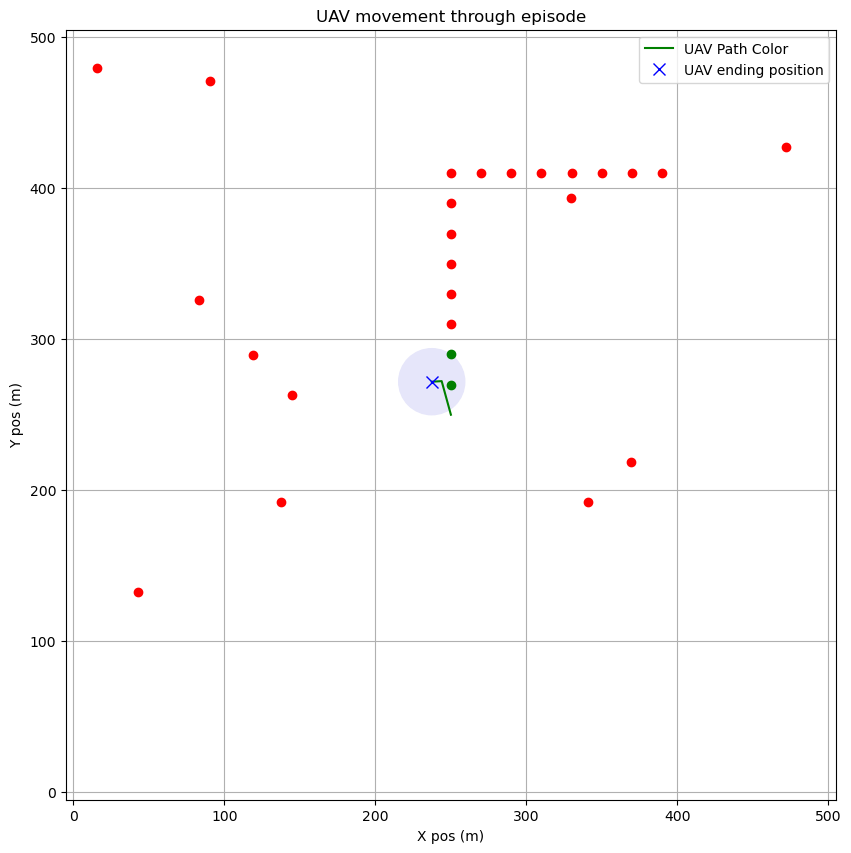

In [6]:
env = Single_Agent_UAV()
state = env.reset()
UAV_positions_list = []
UAV_positions_list.append(state.copy())
a = env.action_space.sample()
print(a)
next_state, reward, done, _ = env.step(a)
print(next_state, reward)
UAV_positions_list.append(next_state.copy())
b = env.action_space.sample()
print(b)
next_state, reward, done, _ = env.step(b)
print(next_state, reward)
UAV_positions_list.append(next_state.copy())
UAV_positions_list = np.array(UAV_positions_list)
print("List",UAV_positions_list)
env.render_UAV_movement_through_episode(UAV_positions_list = UAV_positions_list)

In [7]:
def update_params(optim, network, loss, grad_clip=None, retain_graph=False):
    optim.zero_grad()
    loss.backward(retain_graph=retain_graph)
    if grad_clip is not None:
        for p in network.modules():
            torch.nn.utils.clip_grad_norm_(p.parameters(), grad_clip)
    optim.step()


def soft_update(target, source, tau):
    for t, s in zip(target.parameters(), source.parameters()):
        t.data.copy_(t.data * (1.0 - tau) + s.data * tau)


def hard_update(target, source):
    target.load_state_dict(source.state_dict())


def grad_false(network):
    for param in network.parameters():
        param.requires_grad = False
        
class V(BaseNetwork):
    def __init__(self, num_inputs, num_actions=env.action_space.shape[0], hidden_units=[256, 256],
                 initializer='xavier'):
        super(V, self).__init__()

        self.value = nn.Sequential(
                            nn.Linear(num_inputs, 128),
                            nn.ReLU(),
                            nn.Linear(128, 128),
                            nn.ReLU(),
                            nn.Linear(128, 1))
    def forward(self, x):
        q = self.value(x)
        return q

In [8]:
class Actor(nn.Module):
    def __init__(self,num_in,numact):
        super(Actor,self).__init__()
        
        self.numact=numact
        self.lin1 = nn.Linear(num_in,100)
        self.lin2=nn.Linear(100,100)
        
        self.lin_out=nn.Linear(100,numact)
    def forward(self,state):
        y=T.tanh(self.lin1(state))
        y=T.tanh(self.lin2(y))
        y=T.tanh(self.lin_out(y))
        return y
    def set_std(self,new_action_std):
        self.action_var = torch.full((self.numact,), new_action_std * new_action_std)
        
        
    def get_action(self,state):
        
        means=self.forward(state)
        
        cov_mat = torch.diag(self.action_var).unsqueeze(dim=0).cuda()
        action_var = self.action_var.expand_as(means)
        dist = MultivariateNormal(means+1e-7, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action+1e-7)
        
        return action.detach(), action_logprob.detach()
    def get_entropy(self,state,action):
        means=self.forward(state)
        action_var = self.action_var.expand_as(means)
        cov_mat = torch.diag_embed(action_var).cuda()
      
        dist = MultivariateNormal(means+1e-7, cov_mat)

        action_logprobs = dist.log_prob(action+1e-7)
        dist_entropy = dist.entropy()
 
        
        return action_logprobs, dist_entropy

In [9]:
class Replaybuffer:
    def __init__(self):
        self.states=[]
        self.actions=[]
        self.rewards=[]
        self.next_states=[]
        self.dones=[]
        self.logprobs=[]
    def clear(self):
        self.states=[]
        self.actions=[]
        self.rewards=[]
        self.next_states=[]
        self.dones=[]
        self.logprobs=[]

In [10]:
class Agent:
    def __init__(self,envstr,alpha,beta,gamma,eps_clip,K_epochs,action_std_init,min_action_std,action_std_decay_rate):
        env =Single_Agent_UAV()
        self.act_dim=env.action_space.shape[0]
        self.state_dim=env.observation_space.shape[0]
#         print( self.act_dim)

        self.Actor=Actor(self.state_dim,self.act_dim).to(device)
        self.Actor_old=Actor(self.state_dim,self.act_dim).to(device)
        self.Actor_old.load_state_dict(self.Actor.state_dict())
        self.Value=V(env.observation_space.shape[0],1).to(device)
        self.gamma=gamma
        self.Replaybuffer=Replaybuffer()
        self.optimizer=T.optim.Adam([{'params': self.Actor.parameters(), 'lr': alpha},
                        {'params': self.Value.parameters(), 'lr': beta}])
        self.MseLoss=nn.MSELoss()
        self.grad_clip=1
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.action_std=action_std_init
        self.min_action_std=min_action_std
        self.action_std_decay_rate=action_std_decay_rate
        self.Actor.set_std(self.action_std)
        self.grad_clip=1
    def get_action(self,state):
   
        state=T.FloatTensor(np.array(state).reshape(-1,self.state_dim)).to(device)

   
        action,logprob=self.Actor.get_action(state)
        
        self.Replaybuffer.logprobs.append(logprob)
        self.Replaybuffer.states.append(state)
        self.Replaybuffer.actions.append(action)
        
        return action.detach().cpu().numpy()[0]
    def decay_std(self):
        self.action_std = self.action_std - self.action_std_decay_rate
        self.action_std = round(self.action_std, 4)
        if (self.action_std <= self.min_action_std):
            self.action_std = self.min_action_std
        
        self.Actor.set_std(self.action_std)
            
    def update(self):


        rewards = []
        discounted_reward = 0
        for reward, done in zip(reversed(self.Replaybuffer.rewards), reversed(self.Replaybuffer.dones)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            

        rewards = torch.FloatTensor(rewards).cuda()
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.squeeze(torch.stack(self.Replaybuffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.Replaybuffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.Replaybuffer.logprobs, dim=0)).detach().to(device)


        
        for _ in range(self.K_epochs):
            
            values=self.Value(old_states)
  
            logprobs, dist_entropy = self.Actor.get_entropy(old_states, old_actions)

       
            state_values = torch.squeeze(values)
            
   
            ratios = torch.exp(logprobs - old_logprobs.detach())

  
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
           

            self.optimizer.zero_grad()
            loss.mean().backward()
            for p in self.Actor.modules():
                torch.nn.utils.clip_grad_norm_(p.parameters(), self.grad_clip)
            for p in self.Value.modules():
                torch.nn.utils.clip_grad_norm_(p.parameters(),self.grad_clip)
            self.optimizer.step()

        self.Actor_old.load_state_dict(self.Actor.state_dict())


        self.Replaybuffer.clear()

In [11]:
episodes = 40000   

       
action_std = 0.6                    
action_std_decay_rate = 0.05       
min_action_std = 0.1                

  
K_epochs = 30        

eps_clip = 0.2         
gamma = 0.99           
max_steps=1000
update=max_steps*4
overallsteps=1500000
lr_actor = 0.0003      
lr_critic = 0.001      
string='Single_Agent_UAV'

In [12]:
agent=Agent(string,lr_actor,lr_critic,gamma,eps_clip,K_epochs,action_std,min_action_std,action_std_decay_rate)

In [13]:
env=Single_Agent_UAV()
step=0
rp=0
scores=[]
while step<=overallsteps:
        interscore=0
            
        state = env.reset()
        done=False
        current_ep_reward = 0
    
        for j in range(max_steps):
            step+=1
            
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            interscore+=reward

            agent.Replaybuffer.rewards.append(reward)
            agent.Replaybuffer.dones.append(done)

            # update PPO agent
            if step % 4000 == 0:
                agent.update()


            if step % 100000 == 0:
                agent.decay_std()
            scores.append(interscore)
            
            if done:
                rp+=1
                if rp%40==0:
                    print(np.mean(scores[-100:]),step)
   
                break

-529.0 2000
-507.52 4000
-119.55 6000
-88.15 8000
-388.08 10000
4.06 12000
-599.73 14000
-449.75 16000
-181.67 18000
19.55 20000
-320.35 22000
15
-231.14 23975
-449.51 25975
-448.84 27975
-225.6 29975
-53.84 31975
-408.15 33975
-336.11 35975
-47.68 37975
-407.01 39975
-530.73 41975
-278.24 43975
-24.63 45975
-382.33 47975
-462.34 49975
-541.09 51975
-308.34 53975
15
-66.13 55970
-187.38 57970
-377.17 59970
15
-222.93 61964
15
-314.09 63948
15
-453.21 65942
-271.6 67942
-19.55 69942
30.97 71942
-389.03 73942
38.34 75942
15
20.51 77939
15
-269.1 79937
-583.34 81937
-207.8 83937
-383.34 85937
15
-408.14 87922
-209.53 89922
15
-241.94 91922
15
-184.67 93912
-282.7 95912
144.68 97912
15
5.93 99905
-204.11 101905
15
139.59 103887
-248.29 105887
15
15
15
-2.15 107856
-62.63 109856
15
15
-347.78 111839
-136.77 113839
15
-70.14 115839
-69.63 117839
-317.73 119839
-154.72 121839
15
-337.77 123832
15
-337.41 125826
-127.79 127826
-151.39 129826
15
-184.93 131826
-306.48 133826
15
-181.3 135823
-2

15
15
15
15
16
15
15
15
15
15
15
15
15
141.31 453730
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
16
15
15
348.95 455418
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
631.69 456887
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
284.07 458531
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
136.89 460245
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
209.14 461811
15
15
15
16
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
285.21 463433
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
15
16
15
15
15
260.21 465105
15
15
15
15
15
15
15
15
15
15
16
15
16
15
15
15
15
15
15
15
378.62 466691
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
369.56 468342
15
16
15
15
15
15
15
15
15
15
15
15
15
225.03 470095
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
497.71 471810
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
508.4 473446
15
15
15
15
15
15
15
15
16
15
16


15
15
16
15
15
16
16
15
15
15
15
376.59 591098
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
15
15
15
15
295.04 592492
15
15
15
15
15
15
15
16
15
15
15
15
15
15
16
15
15
16
15
15
15
15
16
15
15
391.18 593992
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
494.0 595454
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
343.59 596794
16
16
15
15
15
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
478.09 598168
15
15
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
518.33 599527
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
539.8 600876
15
15
16
15
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
16
15
16
15
15
15
15
15
518.36 602143
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
711.07 603430
15
15
15
15
15
15
15
16
16
15
15
15
15
16
15
15
15
15
16
15
15
15
15
15
15
1

15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
477.27 686577
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
545.41 687745
16
15
15
15
15
15
16
15
15
15
15
15
16
16
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
297.9 688894
15
15
16
15
15
15
15
15
15
15
15
16
15
16
15
15
15
15
15
15
15
15
15
16
16
15
15
16
15
15
15
545.56 690095
15
15
15
15
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
16
15
15
15
405.78 691270
15
15
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
465.71 692471
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
643.55 693777
15
15
15
16
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
567.76 694812
15
15
15
15
15
15
15
15
15
15
16
15
15
15
16
15
15
15
16
16
15
15
15
15
15
15
15
16
15
15
15
15
15
521.78 695967
16
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
16
16
15
15
15

15
15
15
16
15
15
16
15
15
15
16
16
15
15
16
15
15
16
16
15
15
15
15
16
16
15
16
15
16
16
15
15
15
15
15
15
588.68 755164
15
15
15
15
16
15
15
15
15
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
16
16
15
15
15
608.0 756152
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
606.18 757154
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
692.26 758395
15
15
15
16
15
15
15
15
15
15
16
15
15
15
15
15
16
16
15
15
15
15
15
15
16
15
16
15
15
15
638.36 759520
16
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
16
15
15
15
413.67 760500
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
414.56 761411
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
15
16
15
15
16
15
15
15
15
15
15
15
16
15
15
443.33 762359
15
16
15
15
16
15
15
15
15
15
15
15
15
15
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
1

15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
16
15
15
15
597.35 827671
16
16
16
15
15
15
15
15
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
16
15
15
634.26 828491
15
16
15
15
15
16
15
15
15
15
15
15
16
15
16
15
16
16
15
15
15
16
15
16
15
15
15
15
15
15
15
16
15
16
15
15
682.64 829316
15
15
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
711.51 830210
15
15
15
15
15
16
15
15
15
15
16
15
16
16
15
15
15
15
16
15
15
16
15
16
15
15
16
16
15
15
16
16
15
16
15
15
15
16
638.92 830954
15
15
15
16
16
15
15
15
15
16
15
16
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
646.08 831767
15
15
15
15
15
16
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
16
15
15
15
16
15
16
15
16
15
16
15
16
15
16
271.33 832579
15
15
16
16
16
15
15
15
16
16
15
16
15
15
16
15
15
15
15
15
15
15
15
16
15
16
15
15
15
16
15
15
15
15
663.28 833448
15
15
15
16
15
15
15
15
15
15
16
15
15
15
16
16
15
16


16
15
15
16
15
15
15
15
15
15
663.53 879330
15
15
15
15
16
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
16
16
15
15
16
16
15
15
15
15
15
15
15
15
16
15
15
565.17 880004
15
16
15
15
15
15
15
16
15
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
16
16
16
15
15
15
16
15
16
16
15
16
15
16
15
446.4 880751
16
16
15
15
15
16
16
15
15
16
15
15
16
16
15
15
15
15
15
15
15
16
16
15
15
15
15
15
15
15
15
16
15
15
16
15
16
656.22 881509
15
15
16
15
15
16
16
16
15
15
15
16
16
15
15
15
15
15
15
16
15
15
15
15
16
16
15
16
16
15
15
15
15
16
16
15
649.73 882333
15
15
15
15
15
15
15
15
15
15
15
15
16
15
16
15
16
16
15
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
731.08 883113
15
15
15
15
16
16
16
15
15
15
15
15
16
15
15
15
16
16
16
15
15
15
15
15
16
15
16
15
16
15
15
15
15
15
15
15
644.76 883930
16
15
15
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
729.08 884725
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
16
16
15
15
16
15
1

16
15
16
16
16
15
15
16
15
16
15
15
15
16
15
15
15
15
15
16
15
15
15
602.47 924370
15
15
15
15
15
16
15
15
16
15
15
15
15
15
15
16
16
15
16
16
16
16
15
15
15
15
16
15
16
15
15
16
15
15
16
15
15
618.62 925046
15
15
15
15
15
16
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
16
16
16
15
15
16
15
16
15
15
609.13 925720
15
15
15
15
15
15
15
15
15
15
16
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
16
15
16
625.39 926386
15
15
16
16
15
15
16
16
15
15
15
15
15
15
16
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
15
15
15
15
737.3 926987
15
15
15
15
15
16
15
15
15
15
16
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
593.16 927698
16
15
15
16
15
16
15
15
15
16
15
15
15
15
16
15
16
15
15
15
15
16
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
606.15 928348
15
15
15
15
15
15
16
16
15
16
16
16
16
16
15
15
15
15
15
15
16
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
16
15
15
637.64 928968
16
16
15
16
15
16
16
15
15
15
15
1

15
15
15
15
15
15
16
16
15
15
16
15
15
16
15
15
15
15
16
15
15
677.09 962487
15
15
15
15
16
16
15
15
16
16
15
15
15
15
15
15
15
15
15
16
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
16
15
16
15
661.2 963076
15
15
15
15
16
15
15
15
15
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
16
15
15
15
15
15
16
15
687.13 963785
15
15
16
15
15
15
15
15
15
16
15
15
15
16
16
16
15
15
15
16
15
15
16
15
16
16
15
15
16
15
16
15
15
15
15
15
16
15
15
660.48 964391
16
15
16
15
15
16
15
15
16
15
15
15
15
15
16
15
16
15
15
15
15
15
15
15
15
15
16
16
15
15
16
15
15
15
15
16
15
15
15
677.33 964976
15
15
16
15
16
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
16
15
15
16
15
15
15
15
15
15
16
15
16
15
15
15
15
15
15
15
638.55 965533
15
15
15
16
15
15
15
16
15
15
15
15
16
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
666.68 966109
15
15
15
15
15
15
15
15
15
15
16
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
16
15
15
15
15
15
15
15
15
16
15
15
15
647.78 966704
15
15
15
15
1

15
15
15
15
15
15
15
15
16
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
632.09 1004062
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
16
626.43 1004746
15
15
15
15
15
15
15
16
16
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
16
15
15
15
15
15
631.62 1005425
16
15
16
16
16
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
679.28 1006061
15
15
16
15
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
16
15
15
15
15
16
15
15
15
712.98 1006692
16
15
15
16
15
15
15
15
15
16
16
16
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
637.36 1007256
15
16
15
15
15
15
16
15
15
15
15
15
15
16
15
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
643.01 1007781
15
15
15
15
15
15
16
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
653.

15
15
15
15
15
15
15
618.02 1056072
15
15
16
15
15
15
15
15
15
15
16
15
15
15
16
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
698.21 1056712
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
586.77 1057390
15
15
15
15
16
15
15
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
15
15
15
15
631.14 1057980
15
15
15
15
15
15
15
15
15
15
15
16
15
16
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
649.03 1058649
15
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
614.05 1059440
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
609.96 1060062
15
15
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
15
15
15
15
634.79 1060639
15
15
15
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
15
16
15
15
15
1

15
15
816.25 1108299
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
701.53 1109583
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
762.59 1110763
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
676.54 1112228
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
588.35 1113407
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
802.16 1114540
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
820.14 1115793
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
690.4 1116630
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
625.28 1117290
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
697.46 1118115
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
643.01 1118895
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
464.05 1214600
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
566.64 1215716
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
753.93 1216931
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
721.25 1218293
15
15
15
15
15
15
15
15
15
15
15
15
15
798.27 1219835
15
15
15
15
15
15
15
787.58 1221583
15
15
15
753.5 1223479
15
15
15
15
15
15
704.05 1225268
15
15
15
15
15
15
15
662.2 1227017
15
15
15
789.35 1228912
15
15
15
779.93 1230805
15
767.78 1232768
15
15
15
15
574.95 1234625
15
15
15
15
15
15
815.79 1236414
15
695.7 1238378
15
15
15
15
15
567.12 1240206
15
15
15
15
15
15
15
15
15
15
15
15
15
813.09 1241753
15
15
15
15
15
15
15
15
15
15
15
15
801.99 1243327
15
15
15
15
15
15
15
15
15
15
15
15
15
796.66 1244864
15
15
15
15
15
15
15
15
15
815.2 1246546
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
803.78 1247974
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15

15
16
15
15
15
15
15
15
15
15
16
16
16
15
16
16
15
15
15
15
15
15
15
15
15
16
15
16
16
15
15
15
15
699.31 1294523
15
15
16
16
16
16
15
15
16
15
16
16
15
15
16
16
16
16
16
15
15
15
15
15
15
16
16
15
15
15
15
15
15
15
15
762.37 1295251
15
15
16
16
15
16
15
15
15
16
15
15
16
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
16
15
15
16
15
15
16
15
707.77 1295865
15
15
15
15
15
15
16
16
16
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
16
16
15
15
15
15
15
16
16
15
15
16
681.1 1296512
15
15
16
15
16
16
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
16
16
15
15
15
15
15
15
15
15
15
15
701.67 1297244
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
15
16
16
16
16
15
15
15
15
15
15
15
15
15
15
15
16
725.18 1297820
15
15
15
15
15
15
15
16
15
15
15
15
15
15
16
15
16
15
15
15
15
16
15
15
16
15
16
15
16
15
15
15
15
15
15
15
15
15
683.47 1298440
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
16
15
15
16
16
15
16
15
15
15
15
15
16
689.85 1299053
16

15
15
16
15
15
15
16
16
15
15
15
15
15
15
16
16
16
15
15
15
15
15
15
16
15
16
15
15
15
16
15
15
16
16
15
15
700.86 1328233
15
16
15
15
15
15
15
16
16
16
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
16
15
15
16
15
16
15
15
15
15
15
16
725.43 1328715
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
16
15
16
16
15
16
15
15
15
16
15
15
15
15
16
15
697.6 1329266
15
15
15
16
16
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
16
15
15
15
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
16
705.32 1329738
15
16
15
16
15
15
16
16
16
16
15
15
15
16
15
16
15
16
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
687.91 1330215
16
15
16
15
16
15
15
15
15
15
15
15
15
15
15
16
15
16
15
15
16
15
15
15
15
15
15
15
15
16
15
15
15
16
15
15
15
15
707.47 1330768
16
16
15
15
15
16
15
15
15
15
16
16
16
16
15
15
15
15
16
16
15
16
16
15
15
16
15
15
16
15
16
16
15
15
15
16
16
16
16
15
716.05 1331245
15
16
15
15
15
15
16
16
15
15
15
16
16
15
15
15
15
16
16
15
15
15
16
15
15
15
16

15
16
16
15
15
15
15
15
16
15
16
15
16
716.61 1358764
15
15
15
15
15
15
16
16
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
15
15
16
16
15
16
16
16
16
15
15
15
15
15
732.88 1359249
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
16
15
15
15
15
15
16
15
15
16
15
689.68 1359758
15
15
15
15
15
16
15
15
16
15
15
15
15
16
15
15
16
16
15
15
15
15
16
15
15
15
15
15
15
16
15
15
16
16
15
15
15
15
15
16
728.35 1360240
15
16
16
15
16
16
15
15
15
16
15
15
15
16
15
15
16
15
15
15
15
15
15
15
16
15
16
15
15
15
15
16
16
15
15
16
16
16
737.15 1360803
15
16
15
15
15
15
15
15
16
15
15
16
15
16
16
16
15
15
16
15
16
15
16
16
15
15
16
16
16
15
15
15
15
15
15
15
15
15
15
700.18 1361327
15
15
15
15
15
15
15
15
16
15
16
15
16
16
15
16
16
16
15
15
15
15
16
15
16
15
16
16
15
15
16
15
15
16
15
15
16
16
15
15
725.18 1361803
15
15
15
15
15
16
16
15
15
16
15
15
15
16
15
16
16
16
15
15
15
15
15
15
15
16
15
15
16
15
15
15
15
15
16
15
16
16
15
15
718.64 1362277
15
15
16
15
1

15
15
16
15
15
16
15
16
15
15
16
15
16
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
15
16
16
15
15
729.25 1389780
15
15
16
15
16
16
15
16
15
15
15
16
15
15
15
15
16
15
16
16
16
16
15
15
15
16
15
16
15
15
16
15
15
15
16
15
15
15
16
705.84 1390298
16
16
15
15
15
15
15
16
15
16
15
15
15
15
16
16
16
16
16
15
15
15
15
15
16
15
15
16
15
15
15
15
16
16
15
15
15
16
16
15
713.6 1390783
15
16
15
16
15
16
16
16
15
16
15
15
15
15
16
15
16
16
15
16
16
16
16
15
15
15
15
15
16
15
15
16
15
15
15
15
16
15
16
15
731.49 1391268
15
16
15
15
15
15
16
16
15
16
15
15
15
15
15
15
15
15
16
15
15
16
16
15
15
15
15
16
16
16
16
16
15
16
15
16
16
16
16
15
743.96 1391741
16
15
15
15
16
16
15
15
16
16
15
15
16
15
15
15
15
16
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
16
15
15
15
15
16
16
700.79 1392217
15
15
16
15
15
15
15
15
15
15
15
16
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
16
15
15
15
15
15
15
16
16
15
16
15
16
724.93 1392687
16
15
15
16
15
15
15
16
15
15
15
15
15
16
15
15
15
15
16
15
16
16
15
15
16
15
15

15
16
15
15
15
15
15
15
16
16
15
15
723.35 1426950
15
15
15
15
16
16
16
15
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
16
15
15
724.35 1427427
15
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
16
15
15
16
15
16
15
15
15
15
721.54 1427989
15
15
15
15
15
15
16
15
16
15
15
15
15
15
16
15
15
15
15
16
15
15
15
15
16
15
15
16
15
16
15
15
15
15
15
15
15
16
15
15
704.88 1428468
16
15
16
16
16
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
16
15
15
16
15
722.46 1428954
15
15
16
16
15
15
15
15
15
15
16
16
15
15
15
15
15
16
15
16
15
15
15
15
15
15
15
15
15
15
16
16
16
16
15
15
16
16
15
708.93 1429477
15
15
15
15
15
15
15
15
16
16
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
16
15
15
15
15
16
16
716.95 1430003
15
15
15
15
15
16
16
16
15
15
15
15
15
15
15
16
15
16
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
16
742.51 1430516
15
16
15
15
15
16
1

15
15
717.74 1462529
15
15
15
15
15
15
15
15
16
15
15
15
15
15
16
16
15
15
15
15
15
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
16
16
15
15
718.77 1463041
15
15
15
15
15
15
16
15
16
15
16
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
16
15
15
15
15
15
15
16
15
15
15
15
15
739.83 1463550
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
16
15
15
15
16
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
732.77 1464063
15
15
15
15
15
16
15
15
15
16
15
16
15
15
15
15
15
16
16
16
15
15
16
15
15
15
15
15
15
15
15
15
16
16
16
15
15
15
15
15
732.67 1464588
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
15
16
15
15
727.23 1465097
16
15
15
15
15
15
16
16
15
15
16
15
15
15
15
15
15
15
16
15
15
15
15
16
15
16
16
16
15
15
15
15
15
15
16
15
15
15
15
725.27 1465656
15
15
16
15
16
15
16
15
15
16
15
15
15
15
15
15
15
16
15
16
15
15
16
15
15
15
15
15
15
15
16
16
15
16
15
15
16
15
15
16
733.11 1466175
15
15
16
15
15
16
15
15
15
16
15
15
1

16
15
15
15
16
15
16
15
16
15
15
15
15
15
16
706.31 1495333
15
16
16
15
15
16
15
16
15
15
15
16
15
16
15
16
15
16
15
15
16
15
15
15
15
15
15
15
15
15
15
15
15
15
16
15
16
15
15
15
702.16 1495815
15
16
15
16
15
15
15
15
16
15
15
16
16
16
15
16
15
15
15
15
15
15
16
15
16
15
15
15
15
15
15
16
15
15
15
16
15
15
15
15
714.15 1496290
15
15
15
15
15
15
16
16
15
16
15
15
16
15
15
16
15
16
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
15
15
16
15
16
15
719.93 1496779
15
15
16
15
15
15
16
15
15
15
15
15
15
15
15
16
15
15
15
15
16
16
15
15
16
16
16
15
15
15
15
15
16
15
16
15
15
15
15
684.95 1497310
16
15
15
15
15
15
15
15
15
15
15
15
16
15
15
15
16
16
16
15
16
15
15
15
15
16
16
15
15
15
15
16
16
15
16
16
16
15
15
695.87 1497833
16
15
16
15
15
15
15
15
15
16
16
15
15
15
16
15
15
15
15
16
15
15
16
16
15
15
16
15
16
16
15
15
15
15
15
15
15
15
16
16
711.74 1498326
15
15
15
15
16
16
15
15
16
15
16
15
15
16
15
16
16
15
15
16
15
16
16
15
16
15
16
16
15
15
15
16
15
16
15
15
15
15
16
632.13 1498855
16
1

score 176.0 avg_score 176.0
score 253.0 avg_score 253.0
score 331.0 avg_score 331.0
score 410.0 avg_score 410.0
score 490.0 avg_score 490.0
score 571.0 avg_score 571.0
score 754.0 avg_score 754.0
score 838.0 avg_score 838.0
score 923.0 avg_score 923.0
score 1009.0 avg_score 1009.0
score 1197.0 avg_score 1197.0
score 1185.0 avg_score 1185.0
15
score 1274.0 avg_score 1274.0


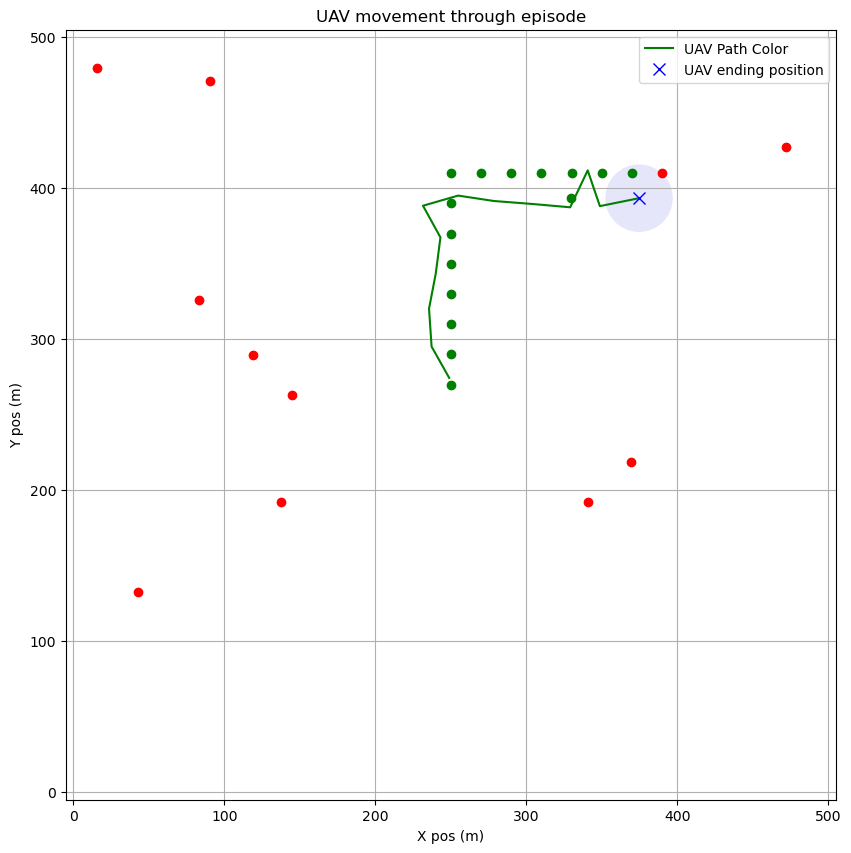

In [14]:
state = env.reset()
done = False
score = 0
UAV_positions_list =[]
while not done:
    action = agent.get_action(state)
    state, reward, done, _ = env.step(action)
    score += reward
    UAV_positions_list.append(state)

    print('score %.1f' % score, 'avg_score %.1f' % score)
UAV_positions_list = np.array(UAV_positions_list)
            # print(UAV_positions_list)
env.render_UAV_movement_through_episode(UAV_positions_list = UAV_positions_list)

In [15]:
df=pd.DataFrame(data={'scores':scores})
df['mean']=df.scores.rolling(100).mean()
df

,scores,mean
0,75,NaN
1,50,NaN
2,25,NaN
3,0,NaN
4,-25,NaN
...,...,...
1500005,818,709.65
1500006,1004,713.20
1500007,1091,716.79
1500008,1179,720.42


<AxesSubplot: >

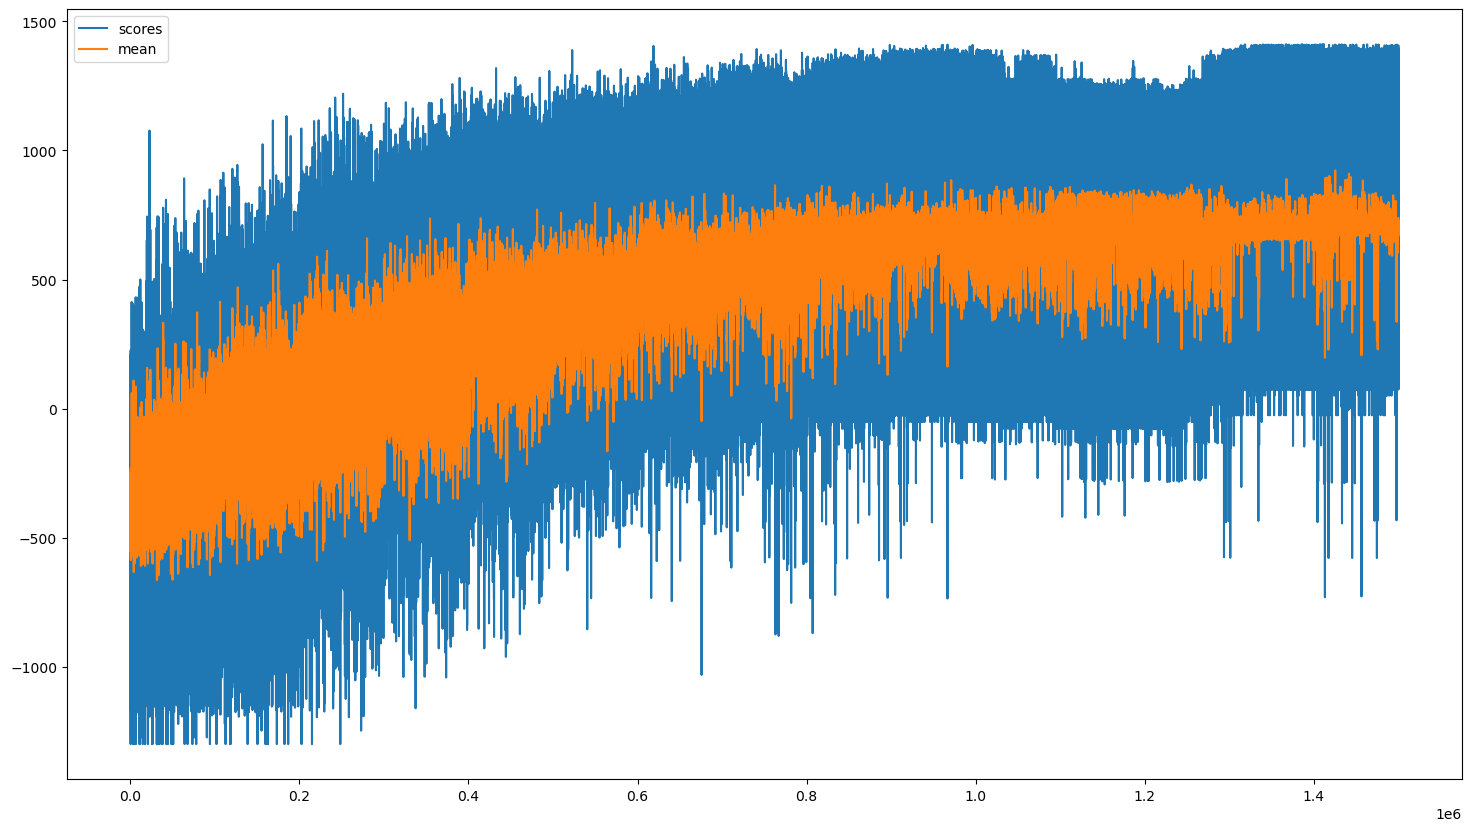

In [16]:
df.plot(figsize=(18,10))